# Intro

The purpose of this file will be to plot a lot of things in map view for any time period or average of time periods.

This will basically be an input (time or time periods), run name, outprint the maps of:

Below surface:
- upper 100 m average T
- upper 100 m average FW content
- AW layer average T
- AW layer average S
- AW layer advection map  # ADVx_SLT, ADVy_SLT, ADVx_TH, ADVy_TH
- AW layer diffusion map  # DFxE_SLT, DFyE_SLT, DFxE_TH, DFyE_TH
- KPPg_SLT


Surface:
- heat flux terms (oceQnet, TFLUX, oceQsw)
- salt flux terms (oceSPflx, SFLUX, oceSflux)
- SST field
- SSS field
- sea ice area
- EXF wind stress (zonal, meridional)

Gateway:
- profile of temperature
- profile of advection through the passage

In [1]:
# import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import gsw
import sys

In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
path = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = path + "diags/BUDG/"
dirState = path + "diags/STATE/"
mymsk = mskBasin == 6

# let's do this exercise for the Barents Sea Lind mask
mymsk = np.load('/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Lind2018/mask_Lind.npz')
mymsk = mymsk['msk1']

In [6]:
# Using np.where to get indices where the mask equals 1
rows, cols = np.where(mymsk == 1)

# Get the extreme indices in each dimension
min_row, max_row = rows.min(), rows.max()
min_col, max_col = cols.min(), cols.max()

print("Bottom edge (min row index):", min_row)
print("Top edge (max row index):", max_row)
print("Left edge (min col index):", min_col)
print("Right edge (max col index):", max_col)

mask = np.zeros_like(mymsk)
max_row -=15
max_col -=15
mask[min_row:max_row,min_col:max_col] = 1
mask[mask == 0] = np.nan
msk_tobin = mask.copy()

Bottom edge (min row index): 524
Top edge (max row index): 552
Left edge (min col index): 34
Right edge (max col index): 58


In [7]:
# also set the xlims and ylims for the given mask
xlims = np.array([420,530])
ylims = np.array([420,560])

xlims = np.array([430,470])
ylims = np.array([480,510])

In [8]:
# set the time files to read from
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2016"] = np.arange(3,5,1)
# times["2007"] = np.arange(5,7,1)
# times["2011"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

2678400.0

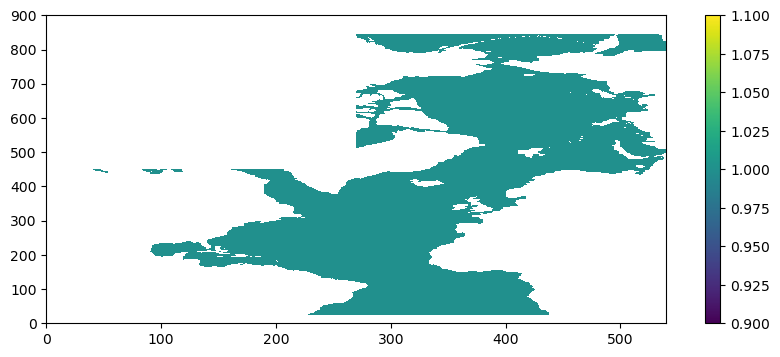

In [9]:
hfC = mygrid['hFacC']
hfC0 = hfC[0]

# Create a copy to modify
hfC_modified = hfC.copy()
hfC0_copy = np.full((ny, nx), np.nan)
hfC0_copy[np.isnan(hfC0)] = 1

# Modify only the copied version
hfC_modified[0] = hfC0_copy

# Plot the modified version
plt.pcolormesh(get_aste_tracer(hfC, nfx, nfy)[0])
plt.colorbar()
plt.show()

In [31]:
hfC[hfC < 1] = np.nan

# do the mapping of the surface forcing terms

In [32]:
TFLUX = np.zeros((len(tsstr),ny,nx))
oceQsw = np.zeros((len(tsstr),ny,nx))

for t in range(len(tsstr)):
    file_name = 'budg2d_zflux_set1'
    meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
    varnames = np.array(["TFLUX","oceQsw"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    TFLUXi,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    oceQswi,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    TFLUXi = TFLUXi.reshape(ny,nx)
    oceQswi = oceQswi.reshape(ny,nx)

    # set in the larger array
    TFLUX[t] = TFLUXi
    oceQsw[t] = oceQswi

# do the time averaging
TFLUX = np.nanmean(TFLUX,axis=0)
oceQsw = np.nanmean(oceQsw,axis=0)

In [33]:
oceQnet = np.zeros((len(tsstr),ny,nx))

for t in range(len(tsstr)):
    file_name = "budg2d_zflux_set2"
    meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
    varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    oceQneti,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    oceQneti = oceQneti.reshape(ny,nx)

    # set in the larger array
    oceQnet[t] = oceQneti

# do the time averaging
oceQnet = np.nanmean(oceQnet,axis=0)

Text(0.5, 0.98, 'Averaged Values from Mar 2016 to Apr 2016')

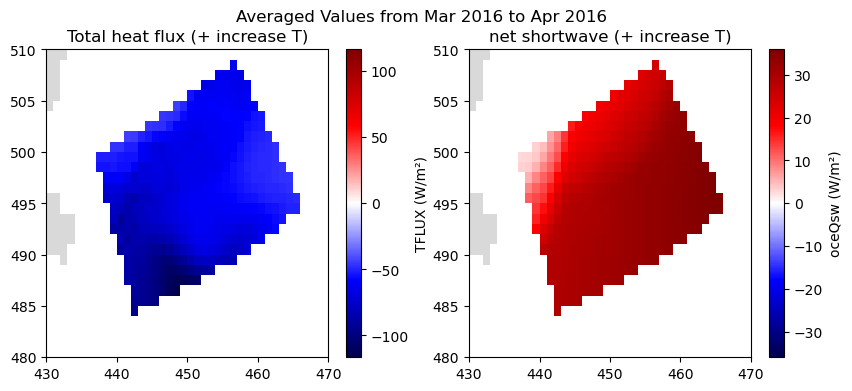

In [34]:
fig = plt.figure(figsize = (10,4))

# first subplot - tflux
ax = plt.subplot(121)
data = TFLUX * mymsk
data[data == 0] = np.nan
# set limits for the colormap
mymin = np.nanmin(data)
mymax = np.nanmax(data)
if mymax > abs(mymin):
    mymin=-mymax
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic",vmin=mymin,vmax=mymin*-1)
cbar = plt.colorbar(cb)
cbar.set_label("TFLUX (W/m²)")
ax.pcolormesh(get_aste_tracer(hfC_modified,nfx,nfy)[0],cmap="Greys",vmin=0,vmax=4)
ax.set_title("Total heat flux (+ increase T)")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# second subplot - shortwave
ax = plt.subplot(122)
data = oceQsw * mymsk
data[data == 0] = np.nan
mymin = np.nanmin(data)
mymax = np.nanmax(data)
if mymax > abs(mymin):
    mymin=-mymax
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic",vmin=mymin,vmax=mymin*-1)
cbar = plt.colorbar(cb)
cbar.set_label("oceQsw (W/m²)")
ax.pcolormesh(get_aste_tracer(hfC_modified,nfx,nfy)[0],cmap="Greys",vmin=0,vmax=4)
ax.set_title("net shortwave (+ increase T)")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# set the title
title = f"Averaged Values from {datetimes[0].strftime('%b %Y')} to {datetimes[-1].strftime('%b %Y')}"
plt.suptitle(title)

In [35]:
# read in the surface salt flux values
SFLUX = np.zeros((len(tsstr),ny,nx))
oceSPflx = np.zeros((len(tsstr),ny,nx))

for t in range(len(tsstr)):
    file_name = 'budg2d_zflux_set1'
    meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
    varnames = np.array(["oceSPflx","SFLUX"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    oceSPflxi,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    SFLUXi,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    oceSPflxi = oceSPflxi.reshape(ny,nx)
    SFLUXi = SFLUXi.reshape(ny,nx)

    # set in the larger array
    SFLUX[t] = SFLUXi
    oceSPflx[t] = oceSPflxi

# do the time averaging
SFLUX = np.nanmean(SFLUX,axis=0)
oceSPflx = np.nanmean(oceSPflx,axis=0)

Text(0.5, 0.98, 'Averaged Values from Mar 2016 to Apr 2016')

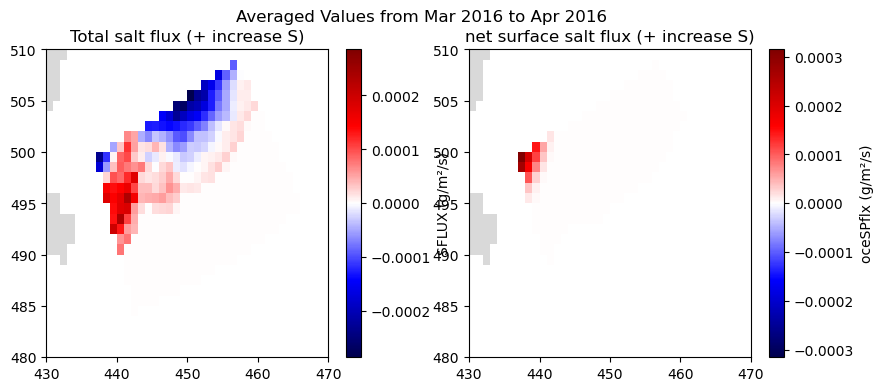

In [36]:
fig = plt.figure(figsize = (10,4))

# first subplot - sflux
ax = plt.subplot(121)
data = SFLUX * mymsk
data[data == 0] = np.nan
# set limits for the colormap
mymin = np.nanmin(data)
mymax = np.nanmax(data)
if mymax > abs(mymin):
    mymin=-mymax
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic",vmin=mymin,vmax=mymin*-1)
cbar = plt.colorbar(cb)
cbar.set_label("SFLUX (g/m²/s)")
ax.pcolormesh(get_aste_tracer(hfC_modified,nfx,nfy)[0],cmap="Greys",vmin=0,vmax=4)
ax.set_title("Total salt flux (+ increase S)")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# second subplot - surface salt flux during freezing
ax = plt.subplot(122)
data = oceSPflx * mymsk
data[data == 0] = np.nan
mymin = np.nanmin(data)
mymax = np.nanmax(data)
if mymax > abs(mymin):
    mymin=-mymax
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic",vmin=mymin,vmax=mymin*-1)
cbar = plt.colorbar(cb)
cbar.set_label("oceSPflx (g/m²/s)")
ax.pcolormesh(get_aste_tracer(hfC_modified,nfx,nfy)[0],cmap="Greys",vmin=0,vmax=4)
ax.set_title("net surface salt flux (+ increase S)")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# set the title
title = f"Averaged Values from {datetimes[0].strftime('%b %Y')} to {datetimes[-1].strftime('%b %Y')}"
plt.suptitle(title)

In [37]:
# do sea ice area, SST, SSS reading the files
# read in the surface salt flux values
THETA = np.zeros((len(tsstr),nz,ny,nx))
SALT = np.zeros((len(tsstr),nz,ny,nx))

for t in range(len(tsstr)):
    file_name = 'state_3d_set1'
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETAi,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    SALTi,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])
    THETAi = THETAi.reshape(nz,ny,nx)
    SALTi = SALTi.reshape(nz,ny,nx)

    # set in the larger array
    THETA[t] = THETAi
    SALT[t] = SALTi

# do the time averaging
THETA = np.nanmean(THETA,axis=0) * hfC
SALT = np.nanmean(SALT,axis=0) * hfC

In [38]:
# do sea ice area, SST, SSS reading the files
# read in the surface salt flux values
SIarea = np.zeros((len(tsstr),ny,nx))

for t in range(len(tsstr)):
    file_name = 'budg2d_snap_set1'
    meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg2d_snap_set1["fldList"])
    varnames = np.array(["SIarea"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    SIareai,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    SIareai = SIareai.reshape(ny,nx)

    # set in the larger array
    SIarea[t] = SIareai

# do the time averaging
SIarea = np.nanmean(SIarea,axis=0)

Text(0.5, 0.98, 'Averaged Values from Mar 2016 to Apr 2016')

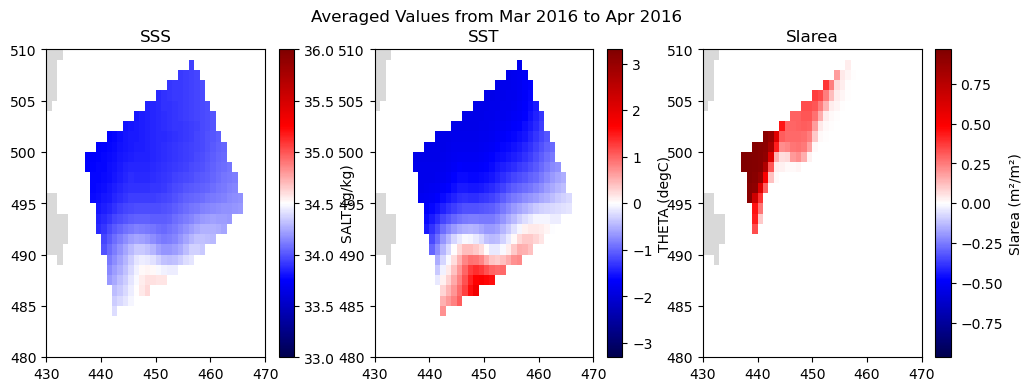

In [39]:
# plot these three

fig = plt.figure(figsize = (12,4))

# first subplot - salt
ax = plt.subplot(131)
data = SALT * mymsk
data[data == 0] = np.nan
# set limits for the colormap
mymin = np.nanmin(data)
mymax = np.nanmax(data)
if mymax > abs(mymin):
    mymin=-mymax

cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic",vmin=33,vmax=36)
cbar = plt.colorbar(cb)
cbar.set_label("SALT (g/kg)")
ax.pcolormesh(get_aste_tracer(hfC_modified,nfx,nfy)[0],cmap="Greys",vmin=0,vmax=4)
ax.set_title("SSS")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# second subplot - temperature
ax = plt.subplot(132)
data = THETA * mymsk
data[data == 0] = np.nan
mymin = np.nanmin(data)
mymax = np.nanmax(data)
if mymax > abs(mymin):
    mymin=-mymax
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic",vmin=mymin,vmax=mymin*-1)
cbar = plt.colorbar(cb)
cbar.set_label("THETA (degC)")
ax.pcolormesh(get_aste_tracer(hfC_modified,nfx,nfy)[0],cmap="Greys",vmin=0,vmax=4)
ax.set_title("SST")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# second subplot - SIarea
ax = plt.subplot(133)
data = SIarea * mymsk
data[data == 0] = np.nan
mymin = np.nanmin(data)
mymax = np.nanmax(data)
if mymax > abs(mymin):
    mymin=-mymax
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic",vmin=mymin,vmax=mymin*-1)
cbar = plt.colorbar(cb)
cbar.set_label("SIarea (m²/m²)")
ax.pcolormesh(get_aste_tracer(hfC_modified,nfx,nfy)[0],cmap="Greys",vmin=0,vmax=4)
ax.set_title("SIarea")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# set the title
title = f"Averaged Values from {datetimes[0].strftime('%b %Y')} to {datetimes[-1].strftime('%b %Y')}"
plt.suptitle(title)

/tmp/ipykernel_1146894/2362224117.py:13: RuntimeWarning: Mean of empty slice
  data = np.nanmean(data[:10],axis=0)
/tmp/ipykernel_1146894/2362224117.py:31: RuntimeWarning: Mean of empty slice
  data = np.nanmean(data[:10],axis=0)


(480.0, 510.0)

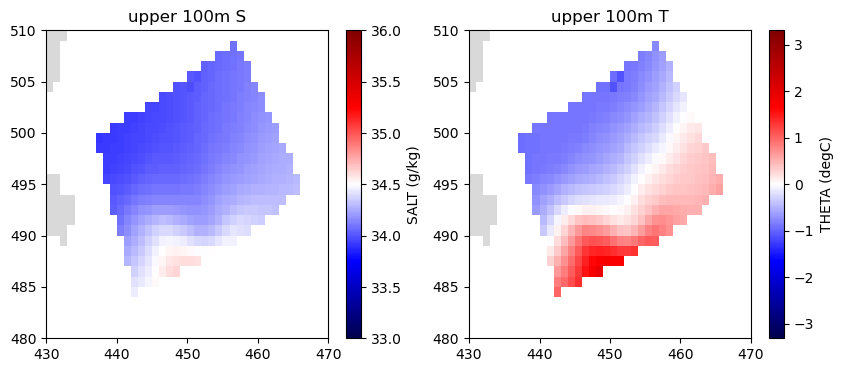

In [17]:
fig = plt.figure(figsize = (10,4))

# first subplot - salt
ax = plt.subplot(121)
data = SALT * mymsk
data[data == 0] = np.nan
# set limits for the colormap
mymin = np.nanmin(data)
mymax = np.nanmax(data)
if mymax > abs(mymin):
    mymin=-mymax

data = np.nanmean(data[:10],axis=0)
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic",vmin=33,vmax=36)
cbar = plt.colorbar(cb)
cbar.set_label("SALT (g/kg)")
ax.pcolormesh(get_aste_tracer(hfC_modified,nfx,nfy)[0],cmap="Greys",vmin=0,vmax=4)
ax.set_title("upper 100m S")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# second subplot - temperature
ax = plt.subplot(122)
data = THETA * mymsk
data[data == 0] = np.nan
mymin = np.nanmin(data)
mymax = np.nanmax(data)
if mymax > abs(mymin):
    mymin=-mymax

data = np.nanmean(data[:10],axis=0)

cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap="seismic",vmin=mymin,vmax=mymin*-1)
cbar = plt.colorbar(cb)
cbar.set_label("THETA (degC)")
ax.pcolormesh(get_aste_tracer(hfC_modified,nfx,nfy)[0],cmap="Greys",vmin=0,vmax=4)
ax.set_title("upper 100m T")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

In [18]:
# also show the gradient of the SST and SSS
# make maps of where SST is > 0  or < 0


# create a new mask based on the total salt flux
data = SFLUX * mymsk
data[data == 0] = np.nan
mymsk_test = np.full(mymsk.shape,np.nan)
mymsk_test[data < 0] = 1
mymsk_test2 = np.full(mymsk.shape,np.nan)
mymsk_test2[data > 0] = 1

# do masks based on the SST (this will tell us the polar Front)
data = THETA[0] * mymsk
data[data == 0] = np.nan
mymsk_test3 = np.full(mymsk.shape,np.nan)
mymsk_test3[data > 0] = 1
mymsk_test4 = np.full(mymsk.shape,np.nan)
mymsk_test4[data < -1] = 1

# create another mask just for the upper 100m where for T between -0.5 and 0.5 and S between 34.4 and 34.8
upper_100m_mask = np.full(mymsk.shape,np.nan)
uo_theta = np.nanmean(THETA[:10],axis=0) * mymsk
uo_salt = np.nanmean(SALT[:10],axis=0) * mymsk
condition = (uo_theta >= -0.5) & (uo_theta <= 0.5) & (uo_salt >= 34.25) & (uo_salt <= 34.5)
upper_100m_mask[condition & (mymsk == 1)] = 1


# save these
np.savez('mask_sflux.npz', msk_nSFLUX=mymsk_test, msk_pSFLUX=mymsk_test2, msk_nSST=mymsk_test4, msk_pSST=mymsk_test3,upper_100m_mask=upper_100m_mask)

/tmp/ipykernel_2432545/2619730366.py:23: RuntimeWarning: Mean of empty slice
  uo_theta = np.nanmean(THETA[:10],axis=0) * mymsk
/tmp/ipykernel_2432545/2619730366.py:24: RuntimeWarning: Mean of empty slice
  uo_salt = np.nanmean(SALT[:10],axis=0) * mymsk


# mapping of advection over the given layers

In [353]:
# read in the advection in temperature
# we can plot this as quivers over the average temperature or average salt of the Arctic or AW layer

# do sea ice area, SST, SSS reading the files
# read in the surface salt flux values
ADVx_TH = np.zeros((len(tsstr),nz,ny,nx))
ADVy_TH = np.zeros((len(tsstr),nz,ny,nx))

for t in range(len(tsstr)):
    file_name = 'budg3d_hflux_set2'
    meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
    varnames = np.array(["ADVx_TH","ADVy_TH"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    ADVx_THi,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    ADVy_THi,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    ADVx_THi = ADVx_THi.reshape(nz,ny,nx)
    ADVy_THi = ADVy_THi.reshape(nz,ny,nx)

    # set in the larger array
    ADVx_TH[t] = ADVx_THi
    ADVy_TH[t] = ADVy_THi

# do the time averaging
ADVx_TH = np.nanmean(ADVx_TH,axis=0) * hfC
ADVy_TH = np.nanmean(ADVy_TH,axis=0) * hfC

# we need to get_aste_vector of these to test if this is working

In [354]:
np.cumsum(mygrid['DRF'])[:10]    # ArW layer
np.cumsum(mygrid['DRF'])[10:24]  # AW layer

array([110.47, 121.27, 133.03, 146.45, 162.49, 182.31, 207.16, 238.26,
       276.68, 323.18, 378.18, 441.68, 513.26, 592.16])

In [355]:
Uo,Vo = get_aste_vector_face1_3(ADVx_TH,ADVy_TH,nfx,nfy,False)
Uo,Vo = Uo[:,:-1,:-1],Vo[:,:-1,:-1]     # centering

/tmp/ipykernel_1085649/1965739615.py:8: RuntimeWarning: Mean of empty slice
  theta_avg = np.nanmean(THETA[:dterm],axis=0)*mymsk
/tmp/ipykernel_1085649/1965739615.py:10: RuntimeWarning: Mean of empty slice
  Uo_avg = np.nanmean(Uo[:dterm],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
/tmp/ipykernel_1085649/1965739615.py:11: RuntimeWarning: Mean of empty slice
  Vo_avg = np.nanmean(Vo[:dterm],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
/tmp/ipykernel_1085649/1965739615.py:22: RuntimeWarning: Mean of empty slice
  ax.pcolormesh(get_aste_tracer(np.nanmean(THETA[:dterm],axis=0),nfx,nfy)[0],vmin=mymin, vmax=-mymin,zorder=0,cmap="seismic",alpha=0.3)
/tmp/ipykernel_1085649/1965739615.py:41: RuntimeWarning: Mean of empty slice
  theta_avg = np.nanmean(THETA[dterm:],axis=0)*mymsk
/tmp/ipykernel_1085649/1965739615.py:43: RuntimeWarning: Mean of empty slice
  Uo_avg = np.nanmean(Uo[dterm:],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
/tmp/ipykernel_1085649/1965739615.py:44: RuntimeWarning: Mean of e

(480.0, 510.0)

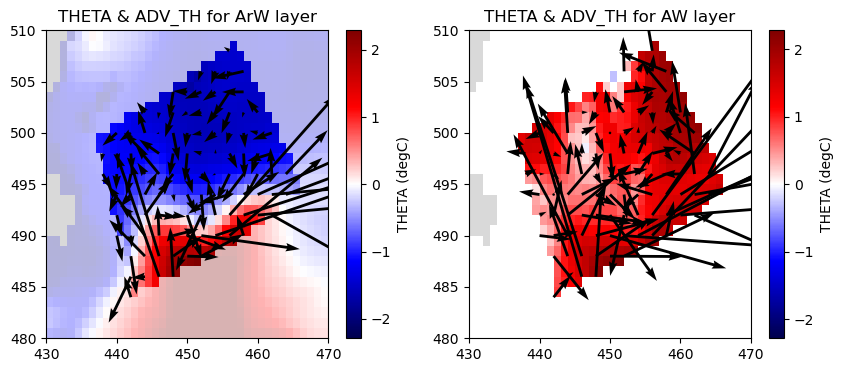

In [387]:
fig = plt.figure(figsize = (10,4))

scale = 1e6

dterm = 10
# first subplot, look at T distribution of the top 100 m
ax = plt.subplot(121)
theta_avg = np.nanmean(THETA[:dterm],axis=0)*mymsk
theta_avg[theta_avg == 0 ] = np.nan
Uo_avg = np.nanmean(Uo[:dterm],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
Vo_avg = np.nanmean(Vo[:dterm],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
Uo_avg[Uo_avg == 0] = np.nan
Vo_avg[Vo_avg == 0] = np.nan
# determine colorbar
mymin = np.nanmin(theta_avg)
mymax = np.nanmax(theta_avg)
if mymax > abs(mymin):
    mymin = -mymax

# Plot temperature field
cb = ax.pcolormesh(get_aste_tracer(theta_avg, nfx, nfy)[0], cmap="seismic", vmin=mymin, vmax=-mymin,zorder=1)
ax.pcolormesh(get_aste_tracer(np.nanmean(THETA[:dterm],axis=0),nfx,nfy)[0],vmin=mymin, vmax=-mymin,zorder=0,cmap="seismic",alpha=0.3)
cbar = plt.colorbar(cb)
cbar.set_label("THETA (degC)")

# Overlay grayscale bathymetry or another reference field
ax.pcolormesh(get_aste_tracer(hfC_modified, nfx, nfy)[0], cmap="Greys", vmin=0, vmax=4)

# Overlay quiver plot of averaged velocity vectors
# Overlay quiver plot of averaged velocity vectors with larger arrows and step every 3
X, Y = np.meshgrid(np.arange(Uo_avg.shape[1]), np.arange(Uo_avg.shape[0]))  # Adjust for your grid
ax.quiver(X[::2, ::2], Y[::2, ::2], Uo_avg[::2, ::2], Vo_avg[::2, ::2],scale=scale, color='black',width=0.01,zorder=2)

# Set plot properties
ax.set_title("THETA & ADV_TH for ArW layer")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# second subplot, look at T distribution of the AW layer (100 m-- in the Barents Sea)
ax = plt.subplot(122)
theta_avg = np.nanmean(THETA[dterm:],axis=0)*mymsk
theta_avg[theta_avg == 0 ] = np.nan
Uo_avg = np.nanmean(Uo[dterm:],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
Vo_avg = np.nanmean(Vo[dterm:],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
Uo_avg[Uo_avg == 0] = np.nan
Vo_avg[Vo_avg == 0] = np.nan
# determine colorbar
mymin = np.nanmin(theta_avg)
mymax = np.nanmax(theta_avg)
if mymax > abs(mymin):
    mymin = -mymax

# Plot temperature field
cb = ax.pcolormesh(get_aste_tracer(theta_avg, nfx, nfy)[0], cmap="seismic", vmin=mymin, vmax=-mymin,zorder=1)
ax.pcolormesh(get_aste_tracer(np.nanmean(THETA[dterm:],axis=0),nfx,nfy)[0],vmin=mymin, vmax=-mymin,zorder=0,cmap="seismic",alpha=0.3)
cbar = plt.colorbar(cb)
cbar.set_label("THETA (degC)")

# Overlay grayscale bathymetry or another reference field
ax.pcolormesh(get_aste_tracer(hfC_modified, nfx, nfy)[0], cmap="Greys", vmin=0, vmax=4)

# Overlay quiver plot of averaged velocity vectors
# Overlay quiver plot of averaged velocity vectors with larger arrows and step every 3
X, Y = np.meshgrid(np.arange(Uo_avg.shape[1]), np.arange(Uo_avg.shape[0]))  # Adjust for your grid
ax.quiver(X[::2, ::2], Y[::2, ::2], Uo_avg[::2, ::2], Vo_avg[::2, ::2],scale=scale, color='black',width=0.01,zorder=2)

# Set plot properties
ax.set_title("THETA & ADV_TH for AW layer")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

In [377]:
# read in the advection in temperature
# we can plot this as quivers over the average temperature or average salt of the Arctic or AW layer

# do sea ice area, SST, SSS reading the files
# read in the surface salt flux values
ADVx_SLT = np.zeros((len(tsstr),nz,ny,nx))
ADVy_SLT = np.zeros((len(tsstr),nz,ny,nx))

for t in range(len(tsstr)):
    file_name = 'budg3d_hflux_set2'
    meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
    varnames = np.array(["ADVx_SLT","ADVy_SLT"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    ADVx_SLTi,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    ADVy_SLTi,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    ADVx_SLTi = ADVx_SLTi.reshape(nz,ny,nx)
    ADVy_SLTi = ADVy_SLTi.reshape(nz,ny,nx)

    # set in the larger array
    ADVx_SLT[t] = ADVx_SLTi
    ADVy_SLT[t] = ADVy_SLTi

# do the time averaging
ADVx_SLT = np.nanmean(ADVx_SLT,axis=0) * hfC 
ADVy_SLT = np.nanmean(ADVy_SLT,axis=0) * hfC

# we need to get_aste_vector of these to test if this is working

In [378]:
Uo,Vo = get_aste_vector_face1_3(ADVx_SLT,ADVy_SLT,nfx,nfy,False)
Uo,Vo = Uo[:,:-1,:-1],Vo[:,:-1,:-1]     # centering

/tmp/ipykernel_1085649/2974343611.py:9: RuntimeWarning: Mean of empty slice
  salt_avg = np.nanmean(SALT[:dterm],axis=0)*mymsk
/tmp/ipykernel_1085649/2974343611.py:11: RuntimeWarning: Mean of empty slice
  Uo_avg = np.nanmean(Uo[:dterm],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
/tmp/ipykernel_1085649/2974343611.py:12: RuntimeWarning: Mean of empty slice
  Vo_avg = np.nanmean(Vo[:dterm],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
/tmp/ipykernel_1085649/2974343611.py:22: RuntimeWarning: Mean of empty slice
  ax.pcolormesh(get_aste_tracer(np.nanmean(SALT[:dterm],axis=0),nfx,nfy)[0],vmin=33.5, vmax=35,zorder=0,cmap="seismic",alpha=0.3)
/tmp/ipykernel_1085649/2974343611.py:41: RuntimeWarning: Mean of empty slice
  salt_avg = np.nanmean(SALT[dterm:],axis=0)*mymsk
/tmp/ipykernel_1085649/2974343611.py:43: RuntimeWarning: Mean of empty slice
  Uo_avg = np.nanmean(Uo[dterm:],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
/tmp/ipykernel_1085649/2974343611.py:44: RuntimeWarning: Mean of empty slice

(480.0, 510.0)

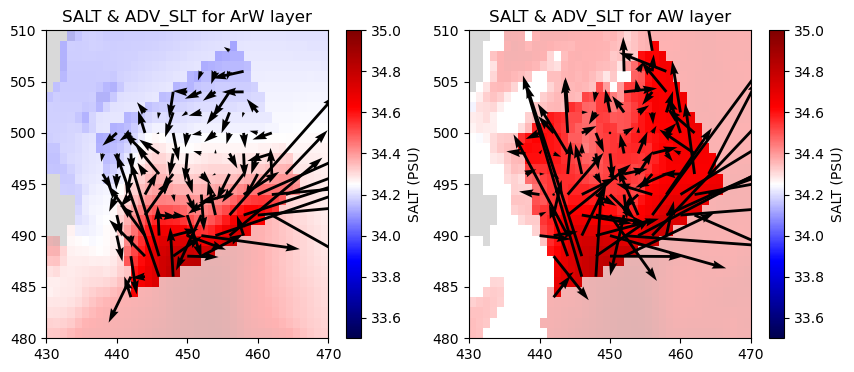

In [394]:
fig = plt.figure(figsize = (10,4))
step = 2

scale = 1e6

dterm = 10
# first subplot, look at T distribution of the top 100 m
ax = plt.subplot(121)
salt_avg = np.nanmean(SALT[:dterm],axis=0)*mymsk
salt_avg[salt_avg == 0 ] = np.nan
Uo_avg = np.nanmean(Uo[:dterm],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
Vo_avg = np.nanmean(Vo[:dterm],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
Uo_avg[Uo_avg == 0] = np.nan
Vo_avg[Vo_avg == 0] = np.nan
# determine colorbar
mymin = np.nanmin(salt_avg)
mymax = np.nanmax(salt_avg)
if mymax > abs(mymin):
    mymin = -mymax
# Plot salt field
cb = ax.pcolormesh(get_aste_tracer(salt_avg, nfx, nfy)[0], cmap="seismic", vmin=33.5, vmax=35,zorder=1)
ax.pcolormesh(get_aste_tracer(np.nanmean(SALT[:dterm],axis=0),nfx,nfy)[0],vmin=33.5, vmax=35,zorder=0,cmap="seismic",alpha=0.3)
cbar = plt.colorbar(cb)
cbar.set_label("SALT (PSU)")

# Overlay grayscale bathymetry or another reference field
ax.pcolormesh(get_aste_tracer(hfC_modified, nfx, nfy)[0], cmap="Greys", vmin=0, vmax=4)

# Overlay quiver plot of averaged velocity vectors
# Overlay quiver plot of averaged velocity vectors with larger arrows and step every 3
X, Y = np.meshgrid(np.arange(Uo_avg.shape[1]), np.arange(Uo_avg.shape[0]))  # Adjust for your grid
ax.quiver(X[::step, ::step], Y[::step, ::step], Uo_avg[::step, ::step], Vo_avg[::step, ::step],scale=scale, color='black',width=0.01,zorder=2)

# Set plot properties
ax.set_title("SALT & ADV_SLT for ArW layer")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# second subplot, look at T distribution of the AW layer (100 m-- in the Barents Sea)
ax = plt.subplot(122)
salt_avg = np.nanmean(SALT[dterm:],axis=0)*mymsk
salt_avg[salt_avg == 0 ] = np.nan
Uo_avg = np.nanmean(Uo[dterm:],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
Vo_avg = np.nanmean(Vo[dterm:],axis=0) * get_aste_tracer(mymsk,nfx,nfy)[0]
Uo_avg[Uo_avg == 0] = np.nan
Vo_avg[Vo_avg == 0] = np.nan
# determine colorbar
mymin = np.nanmin(salt_avg)
mymax = np.nanmax(salt_avg)
if mymax > abs(mymin):
    mymin = -mymax
# Plot temperature field
cb = ax.pcolormesh(get_aste_tracer(salt_avg, nfx, nfy)[0], cmap="seismic", vmin=33.5, vmax=35,zorder=1)
ax.pcolormesh(get_aste_tracer(np.nanmean(SALT[dterm:],axis=0),nfx,nfy)[0],vmin=33.5, vmax=35,zorder=0,cmap="seismic",alpha=0.3)
cbar = plt.colorbar(cb)
cbar.set_label("SALT (PSU)")

# Overlay grayscale bathymetry or another reference field
ax.pcolormesh(get_aste_tracer(hfC_modified, nfx, nfy)[0], cmap="Greys", vmin=0, vmax=4)

# Overlay quiver plot of averaged velocity vectors
# Overlay quiver plot of averaged velocity vectors with larger arrows and step every 3
X, Y = np.meshgrid(np.arange(Uo_avg.shape[1]), np.arange(Uo_avg.shape[0]))  # Adjust for your grid
ax.quiver(X[::step, ::step], Y[::step, ::step], Uo_avg[::step, ::step], Vo_avg[::step, ::step],scale=scale, color='black',width=0.01,zorder=2)

# Set plot properties
ax.set_title("SALT & ADV_SLT for AW layer")
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# plot the UVELMASS and VVELMASS

In [24]:
# load the UVELMASS and VVELMASS
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])  # m/s

UVELMASS = UVELMASS.reshape(nz,ny,nx) * np.tile(msk_tobin[np.newaxis,:,:],(nz,1,1))
VVELMASS = VVELMASS.reshape(nz,ny,nx) * np.tile(msk_tobin[np.newaxis,:,:],(nz,1,1))

/tmp/ipykernel_920227/1994758015.py:10: RuntimeWarning: Mean of empty slice
  Uvdata = np.nanmean(Uvdata,axis=0)
/tmp/ipykernel_920227/1994758015.py:11: RuntimeWarning: Mean of empty slice
  Vvdata = np.nanmean(Vvdata,axis=0)


(400.0, 600.0)

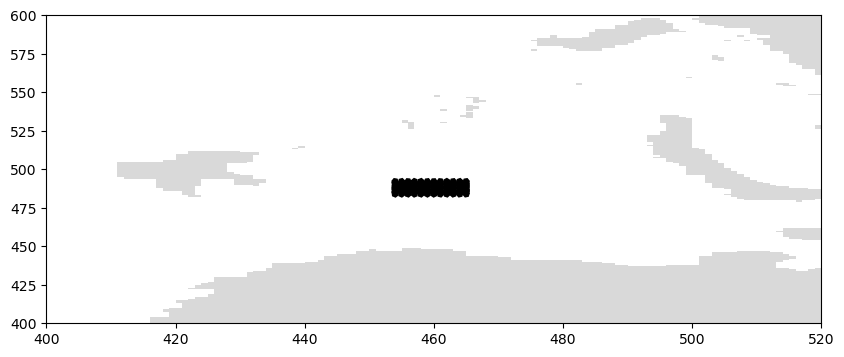

In [27]:
fig = plt.figure(figsize = (10,4))
step = 2

scale = 1e6

dterm = 10
# first subplot, look at T distribution of the top 100 m
ax = plt.subplot(111)
Uvdata,Vvdata = get_aste_vector_face1_3(UVELMASS,VVELMASS,nfx,nfy,False)
Uvdata = np.nanmean(Uvdata,axis=0)
Vvdata = np.nanmean(Vvdata,axis=0)
Uo_avg = Uvdata[:-1,:-1] * get_aste_tracer(mask,nfx,nfy)[0]
Vo_avg = Vvdata[:-1,:-1] * get_aste_tracer(mask,nfx,nfy)[0]
Uo_avg[Uo_avg == 0] = np.nan
Vo_avg[Vo_avg == 0] = np.nan



(470.0, 520.0)

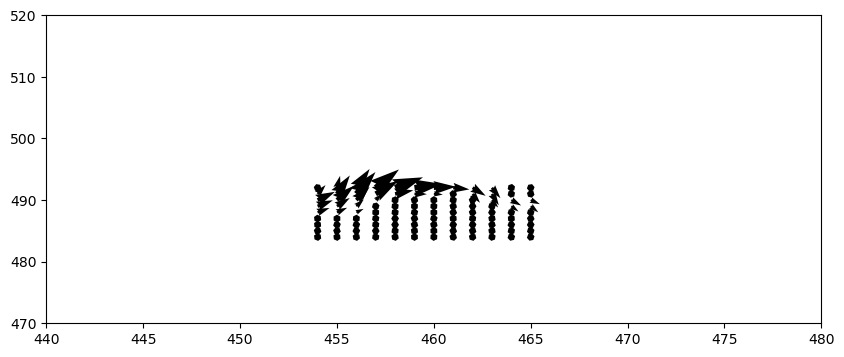

In [36]:

plt.quiver(X, Y, Uo_avg, Vo_avg,scale=1e0, color='black',width=0.01,zorder=2)

# Overlay grayscale bathymetry or another reference field
plt.pcolormesh(get_aste_tracer(hfC_modified, nfx, nfy)[0], cmap="Greys", vmin=0, vmax=4)
plt.xlim(440,480)
plt.ylim(470,520)

# also plot the ADVx terms on the gateway

In [360]:
# gates to the Arctic we're interested in:
    # BSO
    # Svalbard-FranzJosefIslands
    # FranzJosefIslands-NovayaZemlya
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]
# x_sfj needs to be sorted
x_sfj = np.sort(x_sfj)[::-1]
# also flip this lr so we're going west to east
x_sfj = x_sfj[::-1]
y_sfj = y_sfj[::-1]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1
# we also need to do for this one flip lr so we go west to east
x_fjnz = x_fjnz[::-1]
y_fjnz = y_fjnz[::-1]

test = np.full(mskBasin.shape,np.nan)
test[y_bso,x_bso] = 1
test[y_sfj,x_sfj] = 2
test[y_fjnz,x_fjnz] = 3

(400.0, 600.0)

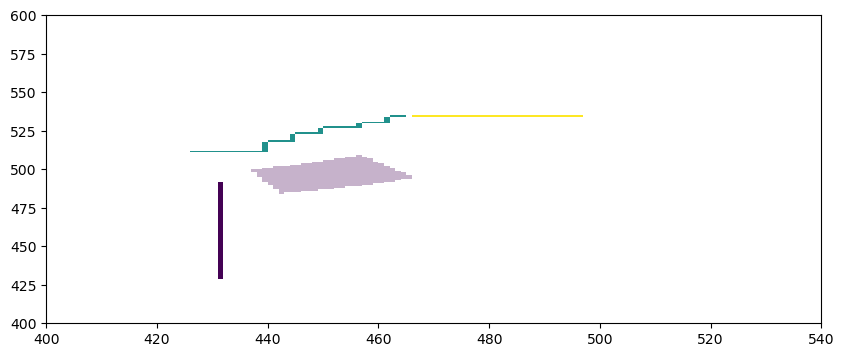

In [361]:
# check the gates
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0],alpha=0.3)
plt.pcolormesh(get_aste_tracer(test,nfx,nfy)[0])
plt.xlim(400,540)
plt.ylim(400,600)

In [362]:
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations

In [363]:
xs = np.array([x_bso,x_sfj,x_fjnz],dtype="object")
ys = np.array([y_bso,y_sfj,y_fjnz],dtype="object")

In [364]:
gateids = np.array([1,2,3])
names = np.array(["BSO","Svbd-FranzJosefIsl","FranzJosefIsl-NovZem"])

In [365]:
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)

In [366]:
choose_UVs = np.array([choose_UV_bso,choose_UV_sfj,choose_UV_fjnz],dtype="object")

In [367]:
# do a sample for the BSO
bso_adv_th = np.zeros((nz,len(x_bso)))

# get the distance from coast to coast from DXG and DYG
distance = np.array([])

# get the adv values
for i in range(len(x_bso)):
    thisy = y_bso[i]
    thisx = x_bso[i]
    this_choose = choose_UV_bso[i]

    if this_choose == 'H':
        bso_adv_th[:,i] = ADVx_TH[:,thisy,thisx]         # + into Barents Sea
        distance = np.append(distance,(mygrid['DYG'][thisy,thisx]))
    else:
        bso_adv_th[:,i] = -ADVy_TH[:,thisy,thisx]         # do - so + is into Barents Sea
        distance = np.append(distance,(mygrid['DXG'][thisy,thisx]))



Text(0, 0.5, 'Depth (m)')

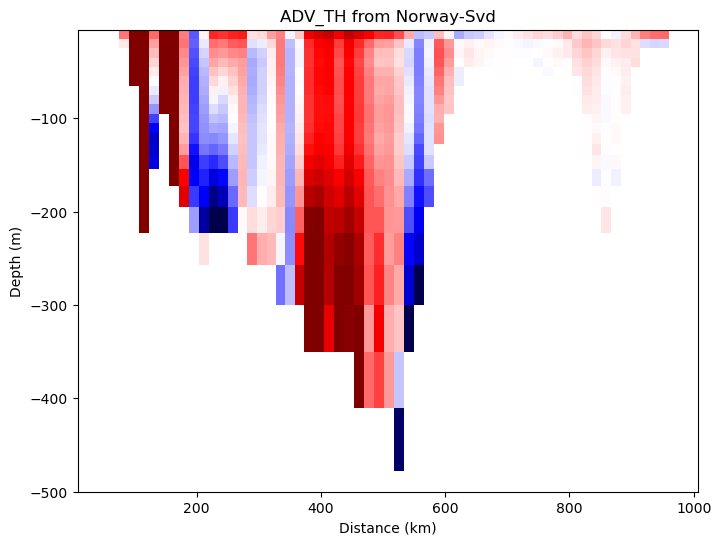

In [368]:
# x = np.arange(0, len(x_bso))
x = np.cumsum(distance/1000)

# Compute cumulative sum of DRF for the y-axis
y = np.cumsum(-mygrid['DRF'])

# Create the plot
plt.figure(figsize=(8, 6))
plt.pcolormesh(x, y, bso_adv_th, cmap='seismic', vmin=-1e5, vmax=1e5)
plt.title("ADV_TH from Norway-Svd")
plt.ylim(-500,-5)
plt.xlabel("Distance (km)")
plt.ylabel("Depth (m)")

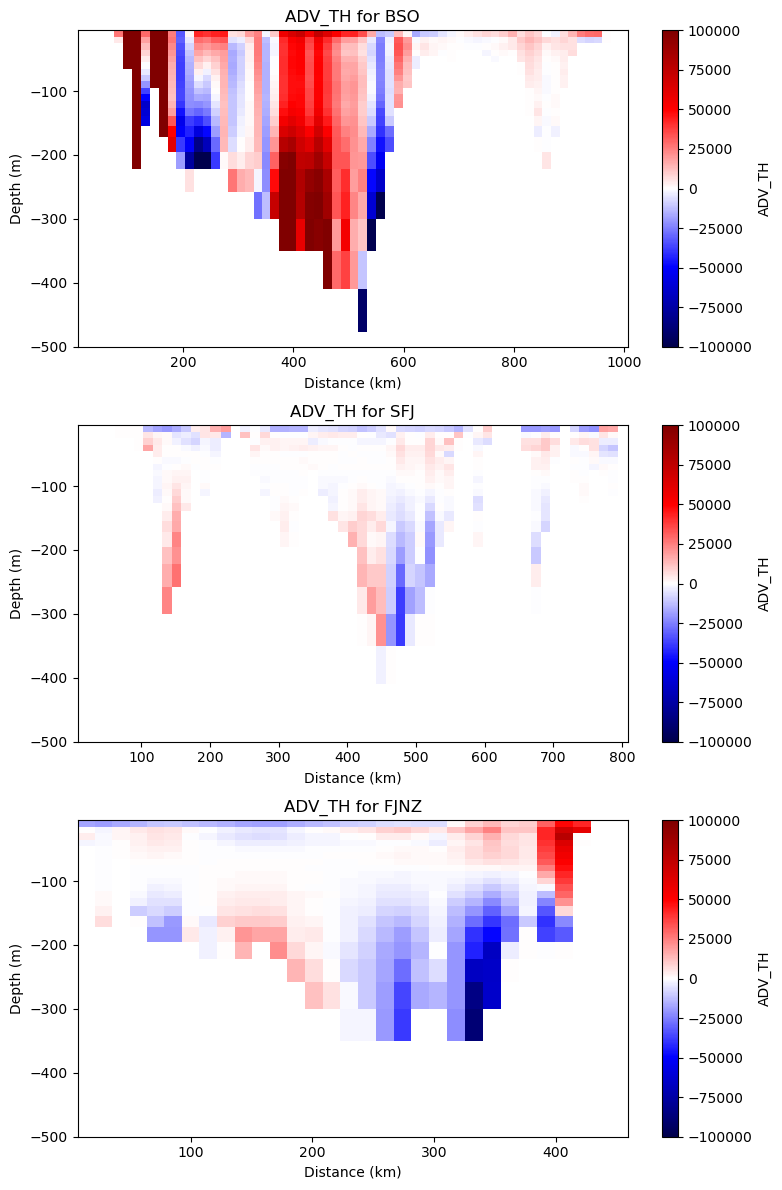

In [369]:
# Store gate names for labeling
gate_names = ["BSO", "SFJ", "FJNZ"]

# Initialize a dictionary to store advection values and distances for each gate
adv_th_dict = {}

# Loop through each gate
for gate_idx in range(len(xs)):
    x_gate = xs[gate_idx]
    y_gate = ys[gate_idx]
    gate_name = gate_names[gate_idx]
    choose_UV = choose_UVs[gate_idx]

    # Initialize the advection array for this gate
    adv_th = np.zeros((nz, len(x_gate)))
    distance = np.array([])  # Distance from coast to coast

    # Loop through the points in this gate
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV[i]  # Ensure this variable is appropriate for all gates

        if gate_idx == 0:
            if this_choose == 'H':
                adv_th[:, i] = ADVx_TH[:, thisy, thisx]  # Positive into the basin
                distance = np.append(distance, mygrid['DYG'][thisy, thisx])
            else:
                adv_th[:, i] = -ADVy_TH[:, thisy, thisx]  # Negative so + is into the basin
                distance = np.append(distance, mygrid['DXG'][thisy, thisx])
        elif gate_idx == 1 or gate_idx == 2:
            if this_choose == 'H':
                adv_th[:, i] = -ADVx_TH[:, thisy, thisx]  # negative out of basin
                distance = np.append(distance, mygrid['DYG'][thisy, thisx])
            else:
                adv_th[:, i] = -ADVy_TH[:, thisy, thisx]  # Negative so + is into the basin
                distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    # Store the results in the dictionary
    adv_th_dict[gate_name] = (adv_th, distance)

# Plot each gate separately
fig, axes = plt.subplots(len(xs), 1, figsize=(8, 4 * len(xs)))

if len(xs) == 1:
    axes = [axes]  # Ensure axes is always iterable

for gate_idx, (gate_name, (adv_th, distance)) in enumerate(adv_th_dict.items()):
    x = np.cumsum(distance / 1000)  # Convert to km
    y = np.cumsum(-mygrid['DRF'])  # Cumulative depth in meters
    
    im = axes[gate_idx].pcolormesh(x, y, adv_th, cmap='seismic', vmin=-1e5, vmax=1e5)
    axes[gate_idx].set_ylim(-500, -5)
    axes[gate_idx].set_xlabel("Distance (km)")
    axes[gate_idx].set_ylabel("Depth (m)")
    axes[gate_idx].set_title(f"ADV_TH for {gate_name}")

    fig.colorbar(im, ax=axes[gate_idx], label="ADV_TH")

plt.tight_layout()
plt.show()